## Text mining exercise - spam vs ham classification using Naive Bayes
### Faculty development program - New Horizon College
### 21 Jan 2019
##### author: Kumar Saurabh

In [1]:
import os
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  classification_report
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2019)


In [2]:
#Read data
#dataset source: https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv('data\\spam.csv', engine = 'python', usecols = ['v1','v2'])
df.columns = ['class', 'text']
df['class'].value_counts()


ham     4825
spam     747
Name: class, dtype: int64

In [3]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
def process_text(s):
    ###return list of tokens after processing input string s
    ###tokens are lower case, with punctuations and stopwords removed from string s
    stop_words = stopwords.words('english')
    return [w for w in word_tokenize(s.lower()) if w not in string.punctuation and w not in stop_words]

process_text('I would like a Cheese Burger for lunch.')

['would', 'like', 'cheese', 'burger', 'lunch']

In [5]:
def get_vocab(str_list, vocab_size, tokenizer):
    #str_list is a list of strings
    #vocab_size is an integer indicating number of tokens to keep in the vocabulary
    #tokenizer should be a function that takes a string as input and returns a list of tokens
    words_corpus = []
    for st in str_list:
        words_corpus.extend(tokenizer(st))
    word_counts = Counter(words_corpus)
    top_words = word_counts.most_common(vocab_size)
    vocab = list(list(zip(*top_words))[0])
    return vocab

vocab_size = 1000
vocab = get_vocab(df['text'], vocab_size, process_text)
vocab[0:10] #print top 10 words in the vocab. the sequence of words is in the order of their frequency in the whole corpus

['...', 'u', 'call', "'s", '2', "'m", 'get', 'ur', "n't", 'gt']

In [6]:
class_labels = df['class'].unique()
num_class = len(class_labels)
X = np.zeros(shape = (num_class, vocab_size)) #term frequency for each class


In [7]:
text_train, text_test, class_train, class_test = train_test_split(df['text'],df['class'],test_size=0.2)

#use training data to compute term frequency for each class
for class_name, text in zip(class_train, text_train):
    class_index = list(class_labels).index(class_name)
    for word in process_text(text):
        if word in vocab: 
            word_index = vocab.index(word)
            X[class_index, word_index] +=1

print('Top 10 words in vocab:', vocab[0:10])
print('Class labels:',class_labels)
print('Frequency of first 10 vocab words in each class:\n',X[:,0:10])
print('Number of tokens in each class:', X.sum(axis = 1))


Top 10 words in vocab: ['...', 'u', 'call', "'s", '2', "'m", 'get', 'ur', "n't", 'gt']
Class labels: ['ham' 'spam']
Frequency of first 10 vocab words in each class:
 [[1028.  730.  190.  329.  229.  315.  237.  187.  267.  254.]
 [   5.  107.  276.   53.  143.    8.   65.  114.   14.    0.]]
Number of tokens in each class: [23989.  6675.]


In [8]:
#Algo: https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html
#get prior probabilities
prior = np.zeros(num_class)
for i,cls in enumerate(class_labels):
    prior[i] = sum(class_train == class_labels[i])/(len(class_train))

#condtional probabilites for the words in vocab    
class_cond_probabilities = (X+1)/(X.sum(axis = 1) + vocab_size).reshape(num_class, 1)

print('prior:', prior)
print('class condtional probabilities for first 10 words in vocab:\n', class_cond_probabilities[:, 0:10])

prior: [0.86650213 0.13349787]
class condtional probabilities for first 10 words in vocab:
 [[0.04117812 0.02925287 0.00764336 0.01320581 0.00920405 0.01264556
  0.00952419 0.00752331 0.01072472 0.01020449]
 [0.00078176 0.01407166 0.03609121 0.00703583 0.01876221 0.00117264
  0.00859935 0.01498371 0.0019544  0.00013029]]


In [9]:
def applyMultinomialNB(class_labels, vocab, prior, condprob, doc):
    #doc is a string that needs to be classified
    doc_tokens = process_text(doc)
    score = np.zeros(len(class_labels))
    for i,cls in enumerate(class_labels):
        score[i] = np.log(prior[i])
        for tok in doc_tokens:
            if tok in vocab: 
                tok_index = vocab.index(tok)
                score[i] += np.log(condprob[i][tok_index])
    return class_labels[score.argmax()]


predicted_labels = [applyMultinomialNB(class_labels, vocab, prior, class_cond_probabilities, text) for text in text_test]
pd.DataFrame({'text':text_test, 'labels':predicted_labels}).head()

,labels,text
454,spam,"Loan for any purpose å£500 - å£75,000. Homeown..."
3466,spam,URGENT! We are trying to contact U. Todays dra...
581,ham,Ok anyway no need to change with what you said
2231,ham,"K, wen ur free come to my home and also tel vi..."
2959,ham,Sir send to group mail check it.


In [10]:
results = pd.DataFrame({'actual' : class_test, 'predicted' : predicted_labels})
cm = confusion_matrix(y_true = class_test, y_pred = predicted_labels, labels = class_labels)
cm

array([[953,  10],
       [ 10, 142]], dtype=int64)

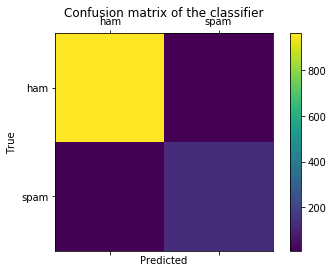

In [28]:
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(class_labels))
ax.set_yticklabels([''] + list(class_labels))
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()